# Autoencoder

Fernando Gonçalves Campos - 12542352

 Imports

In [1150]:
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod

## Custom Classes

Classes used to create the auto-encoder.\
Example of how to use these classes in the end of the section

### Class definitions

#### Custom loss functions

Base Class

`__call__`: calculates the loss.\
`deriv`: derivative of the loss function, used in backpropagation.

In [1151]:
class Loss(ABC):
    @abstractmethod
    def __call__(self, y_hat: np.ndarray, y: np.ndarray) -> float:
        pass

    @abstractmethod
    def deriv(self, y_hat: np.ndarray, y: np.ndarray) -> np.ndarray:
        pass

Mean Square Error (MSE)

In [1152]:
class MSE(Loss):
    def __call__(self, y_hat: np.ndarray, y: np.ndarray) -> float:
        return np.mean(np.square(y_hat - y))

    def deriv(self, y_hat: np.ndarray, y: np.ndarray) -> np.ndarray:
        return 2 * (y_hat - y)

#### Custom Activation Functions

Base Class

`__call__`: Calculates the "activated" values from the input.\
`deriv`: derivative used in the backpropagation.

In [1153]:
class Activation(ABC):
    @abstractmethod
    def __call__(self, X: np.ndarray) -> np.ndarray:
        pass

    @abstractmethod
    def deriv(self, X: np.ndarray) -> np.ndarray:
        pass

ReLU

In [1154]:
class ReLU(Activation):
    def __init__(self, alpha: float = 0):
        self.alpha = alpha

    def __call__(self, X: np.ndarray) -> np.ndarray:
        y = X
        y[y < 0] *= self.alpha
        return y

    def deriv(self, X: np.ndarray) -> np.ndarray:
        y = np.ones(X.shape)
        y[X <= 0] = self.alpha
        return y

Sigmoid

In [1155]:
class Sigmoid(Activation):
    def __call__(self, X: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-X))

    def deriv(self, X: np.ndarray) -> np.ndarray:
        f = self(X)
        return f * (1 - f)

#### Custom Layers

Base Class

`__init__`: Receives the activation function used and the number of nodes.\
`build`: Initializes the weights and bias using the input size passed to the function.\
`__call__`: Return the final results calculated by the layer.\
`forward`: Return values from before and after they were passed through the activation function.

In [1156]:
class Layer(ABC):
    @abstractmethod
    def __init__(self, output_size: int, activation: Activation):
        self.output_size = output_size
        self.activation = activation

    @ abstractmethod
    def build(self, input_size: int) -> None:
        self.weights = np.random.normal(0, 0.5, size=(input_size, self.output_size))
        self.bias = np.random.normal(0, 0.5, size=(1, self.output_size))

    @abstractmethod
    def __call__(self, X: np.ndarray) -> np.ndarray:
        pass

    @abstractmethod
    def forward(self, X: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        pass

Dense Layer

All nodes in the layer are connected to all nodes in the previous layer, each connection having an individual weight.

In [1157]:
class Dense():
    def __init__(self, output_size: int, activation: Activation):
        self.output_size = output_size
        self.activation = activation

    def build(self, input_size: int) -> None:
        self.weights = np.random.normal(0, 0.5, size=(input_size, self.output_size))
        self.bias = np.random.normal(0, 0.5, size=(1, self.output_size))

    def __call__(self, X: np.ndarray) -> np.ndarray:
        return self.activation(np.dot(X, self.weights) + self.bias)

    def forward(self, X: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        output_values = np.dot(X, self.weights) + self.bias
        activation_values = self.activation(output_values)
        return output_values, activation_values

#### Custom Model

This model class follows a similar approach that keras's Sequencial model uses, with some differences.

1) The model is initialized with:
    - The number of inputs received by the model.
    - The loss function used to calculate the gradients.
    - The learning rate (default = 0.01).

2) To add a new layer, is called the function call `add` with:
    - The number of nodes in the layer.
    - The activation function used in the layer.

3) Both `predict` and `__call__` methods can be called passing the inputs to get the outputs from the neural network

4) After adding all layers, **the model needs to be built** calling the method `build`, this initializes the weights and biases for all layers added after the last call to this method

5) `fit` can be called to train the model based on the data passed, this method returns list of the losses, accuracies and epochs when each loss/accuracy was calculated (the accuracy function can be passed as a parameter)

In [1158]:
class Model:
    def __init__(self, input_size: int, loss: Loss, lr: float = 0.01):
        self.lr = lr

        self.loss = loss

        self.n_built_layers = 0
        self.output_size = input_size
        self.input_size = input_size
        self.layers: list[Layer] = []

    def add(self, layer: Layer) -> None:
        self.layers.append(layer)

    def build(self) -> None:
        for i in range(self.n_built_layers, len(self.layers)):
            self.layers[i].build(self.output_size)
            self.output_size = self.layers[i].output_size

        self.n_built_layers = len(self.layers)

    def predict(self, X: np.ndarray) -> np.ndarray:
        y = X
        for layer in self.layers:
            y = layer(y)
        return y

    def __call__(self, X: np.ndarray) -> np.ndarray:
        return self.predict(X)

    def _forward(self, X: np.ndarray) -> tuple[list[np.ndarray], list[np.ndarray]]:
        outputs = []
        activations = [X]

        cur_X = X
        for layer in self.layers:
            output_values, activation_values = layer.forward(cur_X)
            outputs.append(output_values)
            activations.append(activation_values)
            cur_X = activation_values

        return outputs, activations

    def _backward(self, X: np.ndarray, y: np.ndarray, outputs: list[np.ndarray], activations: list[np.ndarray]):
        n = y.size

        error = self.loss.deriv(activations[-1], y) * self.layers[-1].activation.deriv(outputs[-1])

        prev_weights = self.layers[-1].weights
        self.layers[-1].weights -= self.lr * (np.dot(activations[-2].T, error) / n)
        self.layers[-1].bias -= self.lr * (np.sum(error, axis=0) / n)

        for i in reversed(range(len(self.layers) - 1)):
            error = np.dot(error, prev_weights.T) * self.layers[i].activation.deriv(outputs[i])

            prev_weights = self.layers[i].weights
            self.layers[i].weights -= self.lr * (np.dot(activations[i].T, error) / n)
            self.layers[i].bias -= self.lr * (np.sum(error, axis=0) / n)

    def fit(self, X: np.ndarray, y: np.ndarray, epochs: int = 1, log_epochs: int = 0, accuracy_func = lambda x: x):
        epochs_return = []
        loss = []
        accuracy = []

        y_pred = accuracy_func(y)
        for i in range(1, epochs+1):
            outputs, activations = self._forward(X)
            self._backward(X, y, outputs, activations)

            if log_epochs != 0 and (i % log_epochs) == 0:
                y_hat = activations[-1]
                y_hat_pred = accuracy_func(y_hat)
                loss.append(self.loss(y_hat, y))
                accuracy.append(np.mean(y_pred == y_hat_pred))
                epochs_return.append(i)

        return loss, accuracy, epochs_return

### Testing Classes

#### Generating Data

In [1159]:
X = np.vstack([np.random.normal(1, 0.5, (100, 2)),
               np.random.normal(-2, 1, (100, 2)),
               np.random.normal(3, 0.75, (100, 2))])

y = np.hstack([np.zeros(100),
               np.ones(100),
               np.ones(100) + 1])

# normalize the data to in the range [0, 1]
X_min = np.min(X)
X_range = np.max(X) - np.min(X)

X = (X - X_min) / X_range

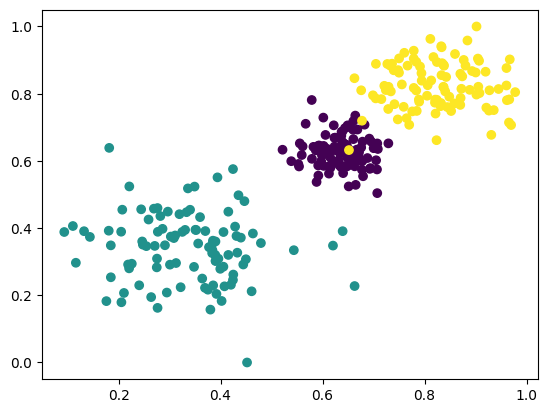

In [1160]:
plt.scatter(X[:,0], X[:,1], c = y)
plt.show()

In [1161]:
def one_hot(y: np.ndarray) -> np.ndarray:
    unique_values = np.unique(y)
    one_hot_y = np.zeros((y.size, len(unique_values)))
    for i, (value) in enumerate(unique_values):
        one_hot_y[(y == value), i] = 1

    return one_hot_y

y = one_hot(y)

In [1162]:
def shuffle_data(X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    permutation_index = np.random.permutation(X.shape[0])
    return X[permutation_index], y[permutation_index]

def filter_data(X: np.ndarray, y: np.ndarray, percentage: float) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    n_train = np.int32(percentage * X.shape[0])

    X_train = X[:n_train]
    y_train = y[:n_train]

    X_test = X[n_train:]
    y_test = y[n_train:]

    return X_train, y_train, X_test, y_test

X, y = shuffle_data(X, y)
X_train, y_train, X_test, y_test = filter_data(X, y, 0.8)

#### Model Training

Create model

In [1163]:
model = Model(2, loss=MSE(), lr=0.007)
# model.add(Dense(10, activation=Sigmoid()))
model.add(Dense(32, activation=ReLU(alpha = 0.5)))
model.add(Dense(32, activation=ReLU(alpha = 0.5)))
model.add(Dense(3, activation=ReLU(alpha = 1)))
model.build()

Training

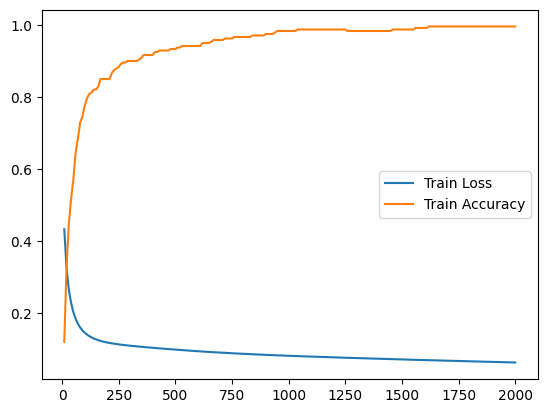

Final train loss:  0.06343260590506161
Final train accuracy:  0.9958333333333333
Final test loss:  0.05867068677012349
Final test accuracy:  0.9833333333333333


In [1164]:
def accuracy_func(X: np.ndarray) -> float:
    return np.argmax(X, axis=1)

# log_epochs = 0 disables the logs
loss, accuracy, epoch_values = model.fit(X_train, y_train, epochs = 2000, log_epochs = 10, accuracy_func = accuracy_func)

if len(epoch_values):
    plt.plot(epoch_values, loss, label="Train Loss")
    plt.plot(epoch_values, accuracy, label = "Train Accuracy")
    plt.legend()
    plt.show()

    print("Final train loss: ", loss[-1])
    print("Final train accuracy: ", accuracy[-1])

    # Printing the performance with the test data
    y_test_pred = accuracy_func(y_test)
    y_test_hat = model.predict(X_test)
    y_test_hat_pred = accuracy_func(y_test_hat)
    print("Final test loss: ", model.loss(y_test_hat, y_test))
    print("Final test accuracy: ", np.sum(y_test_pred == y_test_hat_pred) / y_test_pred.size)

## Autoencoder implementation

### Autoencoder class

1) The autoencoder is initialized by passing to it two models, the encoder and the decoder. The output of the encoder must be the same size of the decoder input.\
**Neither of the models need to be built prior to initializing the class.**\
The parameter "autoNormalize" can be passed to choose if the data needs to be normalized before encoding, this automaticaly returns the data to the original ranges after decoding (default = True).

2) `encode` can be called to encode the values passed to it.

3) `decode` can be called passing the encoded values to get the original scale.

4) If auto normalization is enabled, the model will always normalize the values in relation to the data passed in the first `fit` call, by default it normalizes in the range [0, 1]

6) `fit` can be called to train the model based on the data passed, this method returns list of the losses and epochs when each loss was calculated.

In [1165]:
class Autoencoder:
    def __init__(self, encoder: Model, decoder: Model, autoNormalize = True):
        self.encoder = encoder
        self.decoder = decoder

        self.encoder.build()
        self.decoder.build()

        self.normalization_division = 1
        self.normalization_subtraction = 0
        self.normalizationConfigured = not autoNormalize

    def _configNormalization(self, X: np.ndarray, min_value: float = 0.0, max_value: float = 1.0) -> None:
        X_min = np.min(X)
        X_range = np.max(X) - X_min

        normalization_range = max_value - min_value

        self.normalization_division = X_range / normalization_range
        self.normalization_subtraction = X_min - (min_value * self.normalization_division)

    def _normalize(self, X: np.ndarray) -> np.ndarray:
        return (X - self.normalization_subtraction) / self.normalization_division

    def _reverseNormalization(self, X: np.ndarray) -> np.ndarray:
        return (X * self.normalization_division) + self.normalization_subtraction

    def encode(self, X: np.ndarray) -> np.ndarray:
        normalized_values = self._normalize(X)
        return self.encoder(normalized_values)

    def decode(self, X: np.ndarray) -> np.ndarray:
        normalized_values = self.decoder(X)
        return self._reverseNormalization(normalized_values)

    def _forward(self, X: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        encoder_outputs, encoder_activations = self.encoder._forward(X)
        decoder_outputs, decoder_activations = self.decoder._forward(encoder_activations[-1])

        return encoder_outputs, encoder_activations, decoder_outputs, decoder_activations

    def _backward(
        self,
        X: np.ndarray,
        encoder_outputs: list[np.ndarray],
        encoder_activations: list[np.ndarray],
        decoder_outputs: list[np.ndarray],
        decoder_activations: list[np.ndarray]
    ):
        n = X.size

        error = self.decoder.loss.deriv(decoder_activations[-1], X) * self.decoder.layers[-1].activation.deriv(decoder_outputs[-1])

        prev_weights = self.decoder.layers[-1].weights
        self.decoder.layers[-1].weights -= self.decoder.lr * (np.dot(decoder_activations[-2].T, error) / n)
        self.decoder.layers[-1].bias -= self.decoder.lr * (np.sum(error, axis=0) / n)

        for i in reversed(range(len(self.decoder.layers) - 1)):
            error = np.dot(error, prev_weights.T) * self.decoder.layers[i].activation.deriv(decoder_outputs[i])

            prev_weights = self.decoder.layers[i].weights
            self.decoder.layers[i].weights -= self.decoder.lr * (np.dot(decoder_activations[i].T, error) / n)
            self.decoder.layers[i].bias -= self.decoder.lr * (np.sum(error, axis=0) / n)

        for i in reversed(range(len(self.encoder.layers))):
            error = np.dot(error, prev_weights.T) * self.encoder.layers[i].activation.deriv(encoder_outputs[i])

            prev_weights = self.encoder.layers[i].weights
            self.encoder.layers[i].weights -= self.encoder.lr * (np.dot(encoder_activations[i].T, error) / n)
            self.encoder.layers[i].bias -= self.encoder.lr * (np.sum(error, axis=0) / n)

    def fit(self, X: np.ndarray, epochs: int = 1, log_epochs: int = 0, min_norm_value: float = 0.0, max_norm_value: float = 1.0):
        if not self.normalizationConfigured:
            self._configNormalization(X, min_norm_value, max_norm_value)
            self.normalizationConfigured = True
        normalized_X = self._normalize(X)

        epochs_return = []
        loss = []

        for i in range(epochs):
            encoder_outputs, encoder_activations, decoder_outputs, decoder_activations = self._forward(normalized_X)
            self._backward(normalized_X, encoder_outputs, encoder_activations, decoder_outputs, decoder_activations)

            if log_epochs != 0 and (i % log_epochs) == 0:
                loss.append(self.decoder.loss(self._reverseNormalization(decoder_activations[-1]), X))
                epochs_return.append(i)

        return loss, epochs_return

### Testing Autoencoder

#### Generating Data

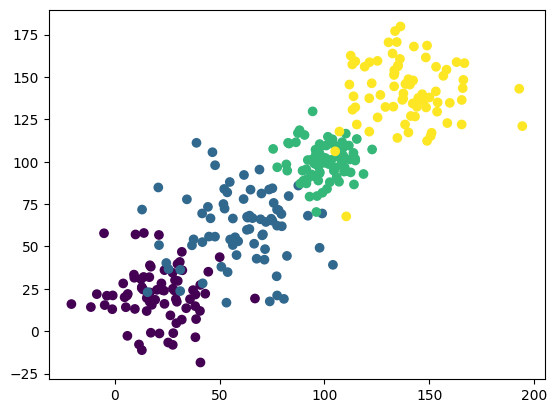

In [1166]:
original_size = 10

n_per_type = 75

X = np.vstack([
    np.random.normal(1, 0.75, (n_per_type, original_size)),
    np.random.normal(3, 1, (n_per_type, original_size)),
    np.random.normal(5, 0.5, (n_per_type, original_size)),
    np.random.normal(7, 1, (n_per_type, original_size))
])
X = X * 20

colors = np.vstack([
    np.full(n_per_type, 1),
    np.full(n_per_type, 2),
    np.full(n_per_type, 3),
    np.full(n_per_type, 4)
])

plt.scatter(X[:,0], X[:,1], c=colors)
plt.show()

In [1167]:
def shuffle_data(X: np.ndarray) -> np.ndarray:
    permutation_index = np.random.permutation(X.shape[0])
    return X[permutation_index]

def filter_data(X: np.ndarray, percentage: float) -> tuple[np.ndarray, np.ndarray]:
    n_train = np.int32(percentage * X.shape[0])

    X_train = X[:n_train]
    X_test = X[n_train:]

    return X_train, X_test

X = shuffle_data(X)
X_train, X_test = filter_data(X, 0.8)

#### Autoencoder training

Function that creates both encoder and decoder models with symmetry

In [1168]:
def create_symmetric_models(original_size: int, compressed_size: int, hidden_layers_sizes: list[int], activation: Activation, lr: float = 0.01) -> tuple[Model, Model]:
    encoder = Model(original_size, loss = MSE(), lr = lr)
    for layer_size in hidden_layers_sizes:
        encoder.add(Dense(layer_size, activation))
    encoder.add(Dense(compressed_size, activation))

    decoder = Model(compressed_size, loss = MSE(), lr = lr)
    for layer_size in reversed(hidden_layers_sizes):
        decoder.add(Dense(layer_size, activation))
    decoder.add(Dense(original_size, ReLU(1))) # Same as linear activation

    return encoder, decoder

Creating the autoencoder

In [1169]:
compressed_size = 5
hidden_layers_sizes = [9, 8]
encoder, decoder = create_symmetric_models(original_size, compressed_size, hidden_layers_sizes, activation = ReLU(0.5), lr = 0.01)

# Example creating the models manually
# encoder = Model(original_size, loss = MSE(), lr = 0.01)
# encoder.add(Dense(9, ReLU(0.5)))
# encoder.add(Dense(8, ReLU(0.5)))
# encoder.add(Dense(compressed_size, ReLU(0.5)))

# decoder = Model(compressed_size, loss = MSE(), lr = 0.01)
# decoder.add(Dense(8, ReLU(0.5)))
# decoder.add(Dense(9, ReLU(0.5)))
# decoder.add(Dense(original_size, ReLU(1))) # Same as linear activation

# Print the number of nodes in each layer
print(encoder.input_size, end=" ")
for layer in encoder.layers:
    print(layer.output_size, end = " ")
for layer in decoder.layers:
    print(layer.output_size, end = " ")

autoencoder = Autoencoder(encoder, decoder, autoNormalize=True)

10 9 8 5 8 9 10 

Training

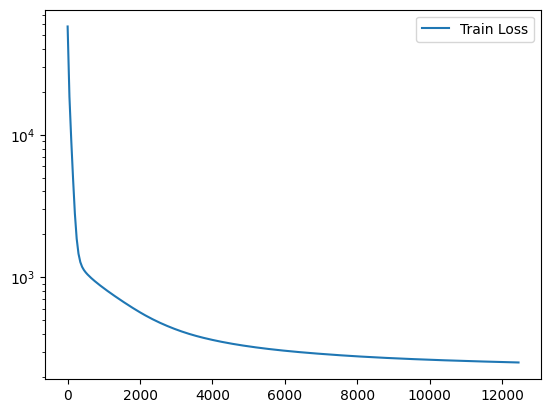

Final train loss:  251.02374288658407
Final test loss:  282.8379732254547


In [1170]:
# log_epochs = 0 disables the logs
loss, epoch_values = autoencoder.fit(X_train, epochs = 12500, log_epochs = 50, min_norm_value = 0.0, max_norm_value = 1.0)

if len(epoch_values):
    plt.plot(epoch_values, loss, label="Train Loss")
    plt.yscale("log") # logarithmic scale for better visualization (otherwise the loss "goest to zero" too quickly)
    plt.legend()
    plt.show()

# Printing the final performance
X_train_hat = autoencoder.decode(autoencoder.encode((X_train)))

# print(X_train[0:5])
# print(X_train_hat[0:5])

print("Final train loss: ", autoencoder.decoder.loss(X_train_hat, X_train))

X_test_hat = autoencoder.decode(autoencoder.encode(X_test))
print("Final test loss: ", autoencoder.decoder.loss(X_test_hat, X_test))